In [80]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, IndexToString
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [52]:
spark = SparkSession.builder.appName('fp').getOrCreate()

In [53]:
data = "clean_Spotify_Youtube.csv"
df = spark.read.csv(data, header=True, inferSchema=True)
df = df.select("Track", "Album", "Danceability", "Energy", "Key", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo", "Likes", "Stream", "Views")

# cast cols as float bc they are initially parsed as str
df = df.withColumn("Danceability", col("Danceability").cast("float"))
df = df.withColumn("Energy", col("Energy").cast("float"))
df = df.withColumn("Key", col("Key").cast("float"))
df = df.withColumn("Loudness", col("Loudness").cast("float"))
df = df.withColumn("Speechiness", col("Speechiness").cast("float"))
df = df.withColumn("Acousticness", col("Acousticness").cast("float"))
df = df.withColumn("Instrumentalness", col("Instrumentalness").cast("float"))
df = df.withColumn("Liveness", col("Liveness").cast("float"))
df = df.withColumn("Valence", col("Valence").cast("float"))
df = df.withColumn("Tempo", col("Tempo").cast("float"))
df = df.withColumn("Likes", col("Likes").cast("float"))
df = df.withColumn("Stream", col("Stream").cast("float"))
df = df.withColumn("Views", col("Views").cast("float"))

# remove any rows with null values
df = df.dropna()


like_quantiles = df.approxQuantile("Likes", [.2, .4, .6, .8], 0.0)
lq20, lq40, lq60, lq80 = like_quantiles
df = df.withColumn("LikeCategories",
                     when(col("Likes") < lq20, "Very Low")
                    .when(col("Likes") < lq40, "Low")
                    .when(col("Likes") < lq60, "Medium")
                    .when(col("Likes") < lq80, "High")
                    .otherwise("Very High")
)


stream_quantiles = df.approxQuantile("Stream", [.2, .4, .6, .8], 0.0)
sq20, sq40, sq60, sq80 = stream_quantiles

df = df.withColumn("StreamCategories",
                     when(col("Stream") < sq20, "Very Low")
                    .when(col("Stream") < sq40, "Low")
                    .when(col("Stream") < sq60, "Medium")
                    .when(col("Stream") < sq80, "High")
                    .otherwise("Very High")
)


df.show(10)

+--------------------+--------------------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+---------+------------+------------+--------------+----------------+
|               Track|               Album|Danceability|Energy| Key|Loudness|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|    Likes|      Stream|       Views|LikeCategories|StreamCategories|
+--------------------+--------------------+------------+------+----+--------+-----------+------------+----------------+--------+-------+-------+---------+------------+------------+--------------+----------------+
|      Feel Good Inc.|          Demon Days|       0.818| 0.705| 6.0|  -6.679|      0.177|     0.00836|         0.00233|   0.613|  0.772|138.559|6220896.0|1.04023488E9|  6.935552E8|     Very High|       Very High|
|     Rhinestone Eyes|       Plastic Beach|       0.676| 0.703| 8.0|  -5.815|     0.0302|      0.0869|         6.87E-4|  0.0463|  0.852| 92.761|1079

<Figure size 700x400 with 0 Axes>

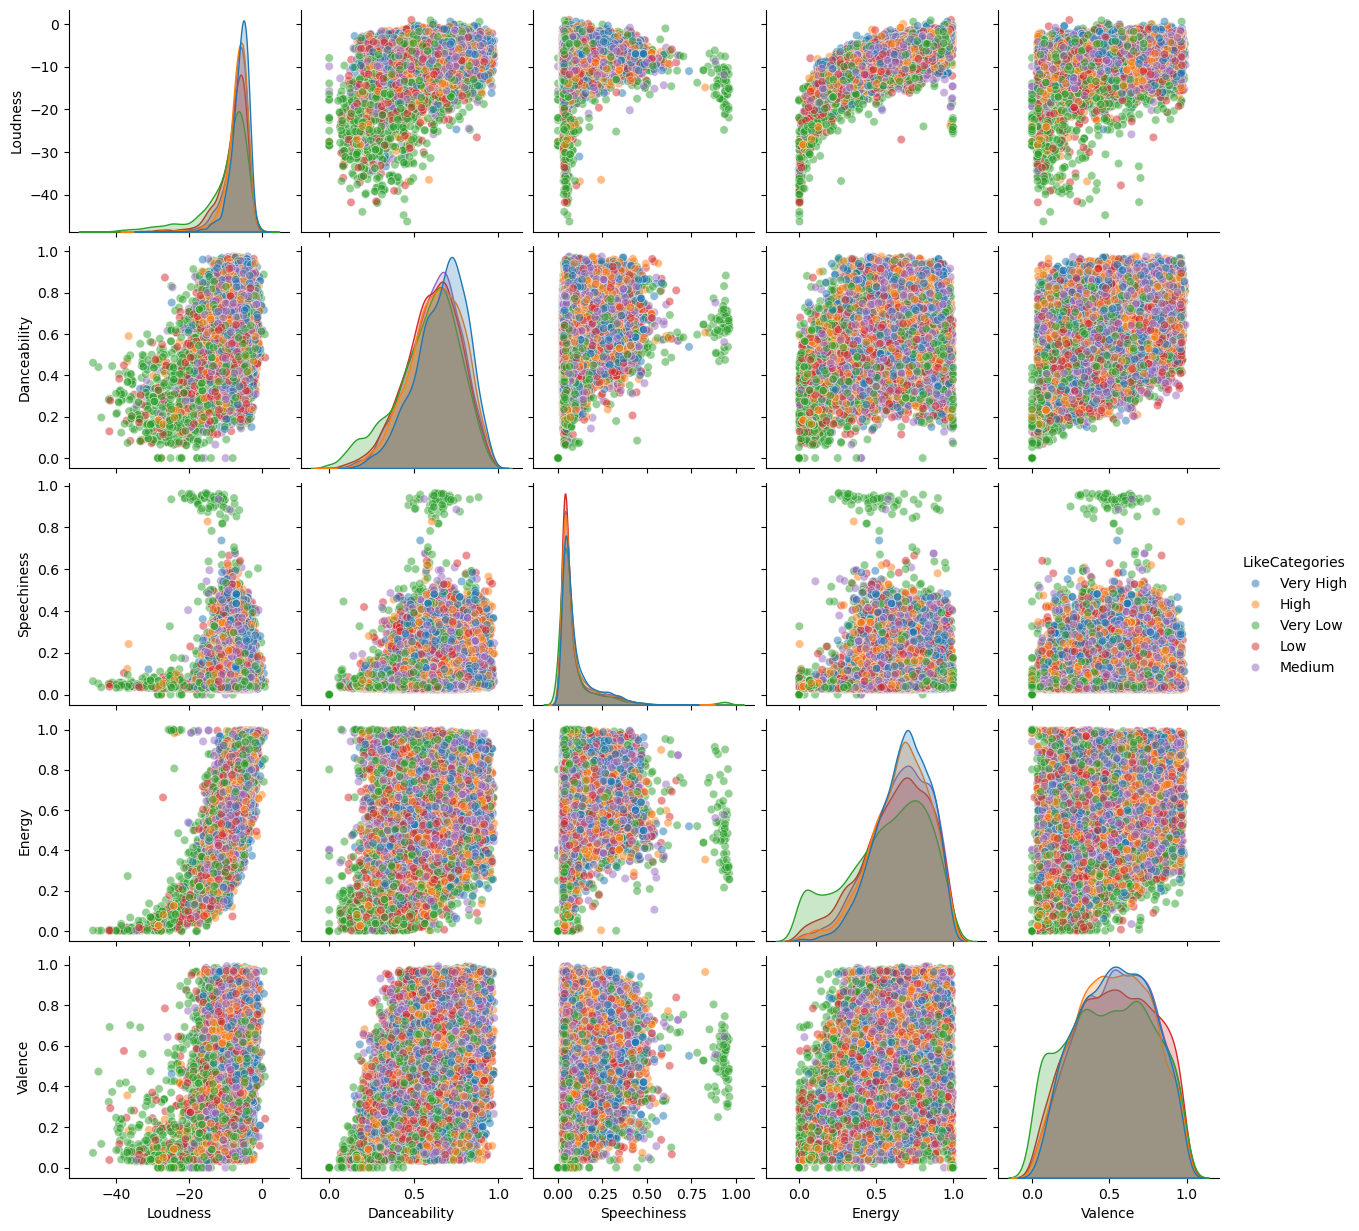

In [67]:
like_pair_df = df.select("LikeCategories", "Loudness", "Danceability", "Speechiness", "Energy", "Valence").toPandas()


plt.figure(figsize=(7, 4))
sns.pairplot(like_pair_df, hue="LikeCategories", diag_kind="kde", plot_kws={"alpha":0.5})

<Figure size 700x400 with 0 Axes>

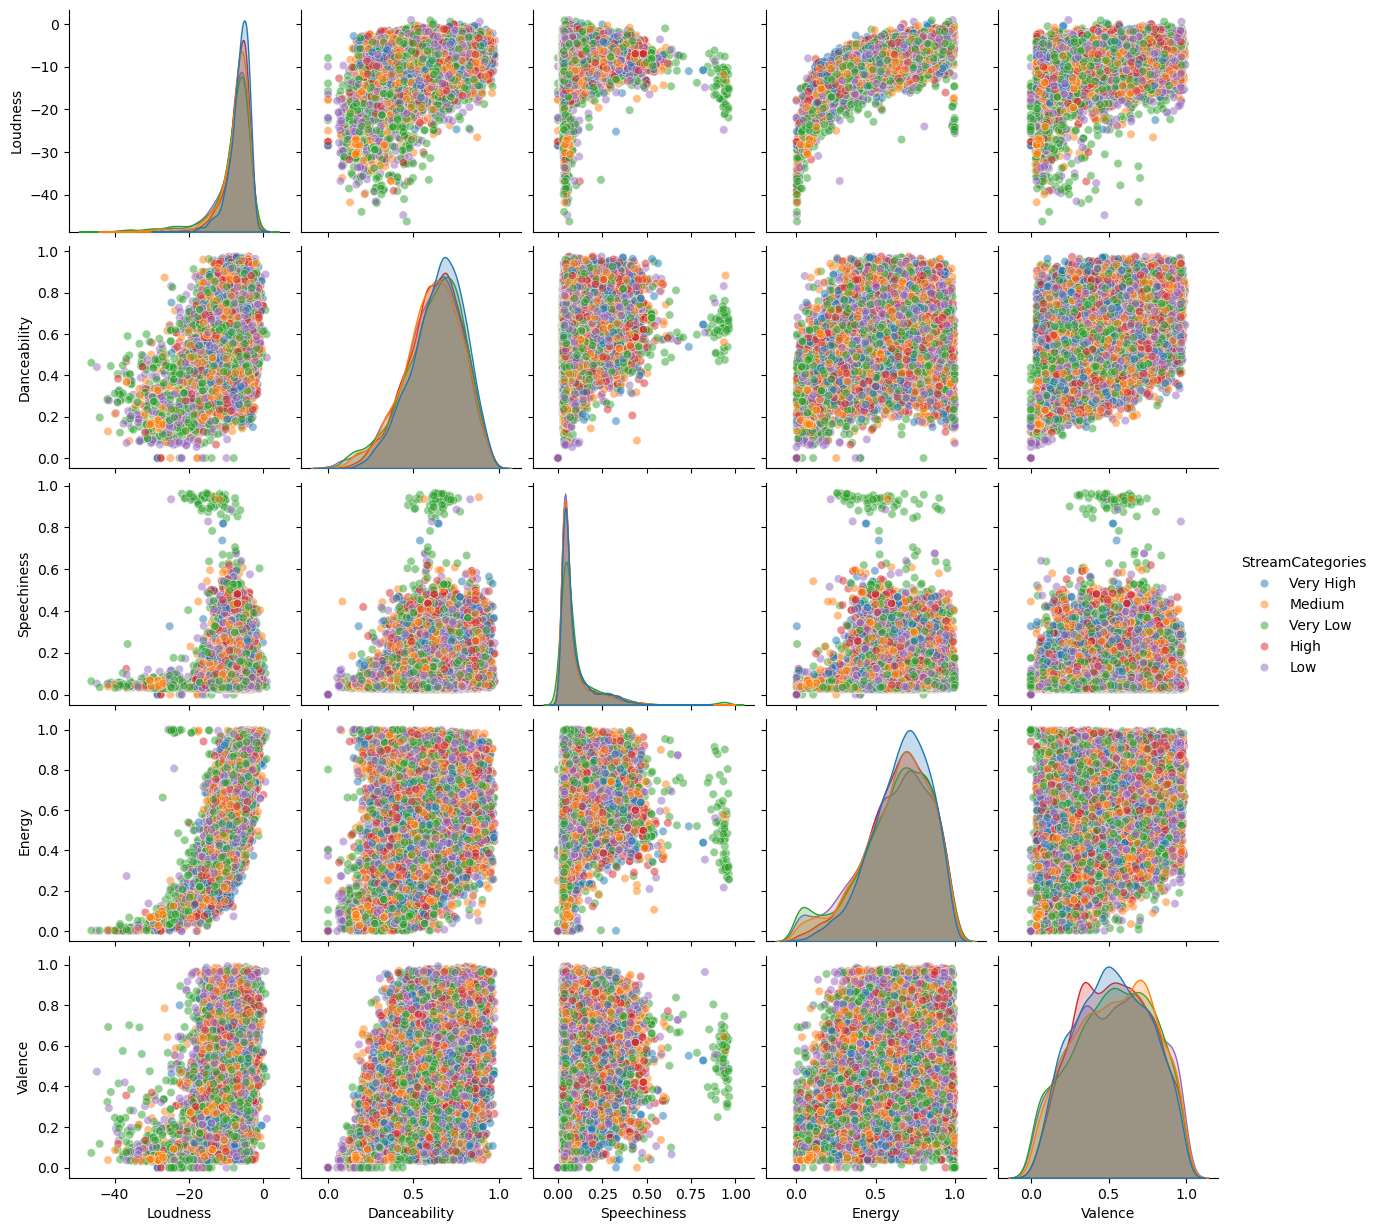

In [68]:
stream_pair_df = df.select("StreamCategories", "Loudness", "Danceability", "Speechiness", "Energy", "Valence").toPandas()   

plt.figure(figsize=(7, 4))
sns.pairplot(stream_pair_df, hue="StreamCategories", diag_kind="kde", plot_kws={"alpha":0.5})

In [54]:
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)

In [55]:
numeric_cols = ["Danceability","Energy","Loudness","Speechiness", "Acousticness","Instrumentalness","Liveness", "Valence","Tempo", "Key"]

assembler = VectorAssembler(inputCols=numeric_cols , outputCol="rawFeatures")
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withMean=True, withStd=True)

like_indexer = StringIndexer(inputCol="LikeCategories", outputCol="LikeLabel")
stream_indexer = StringIndexer(inputCol="StreamCategories", outputCol="StreamLabel")

In [56]:
like_classes = trainDF.select("LikeCategories").distinct().count()

likeForest = RandomForestClassifier(
    labelCol="LikeLabel",
    featuresCol="features",
    numTrees=150,
    maxDepth=10
)

stream_classes = trainDF.select("StreamCategories").distinct().count()

streamForest = RandomForestClassifier(  
    labelCol="StreamLabel",
    featuresCol="features",
    numTrees=150,
    maxDepth=10
)

In [57]:
likePipeline = Pipeline(stages=[assembler, scaler, like_indexer, likeForest]) 
streamPipeline = Pipeline(stages=[assembler, scaler, stream_indexer, streamForest])

In [58]:
like_model = likePipeline.fit(trainDF)
stream_model = streamPipeline.fit(trainDF)   

In [114]:
like_pred = like_model.transform(testDF)
stream_pred = stream_model.transform(testDF)

In [115]:
like_acc = MulticlassClassificationEvaluator(labelCol="LikeLabel", predictionCol="prediction", metricName="accuracy")
stream_acc = MulticlassClassificationEvaluator(labelCol="StreamLabel", predictionCol="prediction", metricName="accuracy")

like_accuracy = like_acc.evaluate(like_pred)
stream_accuracy = stream_acc.evaluate(stream_pred)

In [116]:
print("Like Accuracy: ", round(like_accuracy, 4))  
print("Stream Accuracy: ", round(stream_accuracy, 4))

Like Accuracy:  0.314
Stream Accuracy:  0.2979


In [120]:
like_label_indexer = like_model.stages[-2]
like_class_names = like_label_indexer.labels

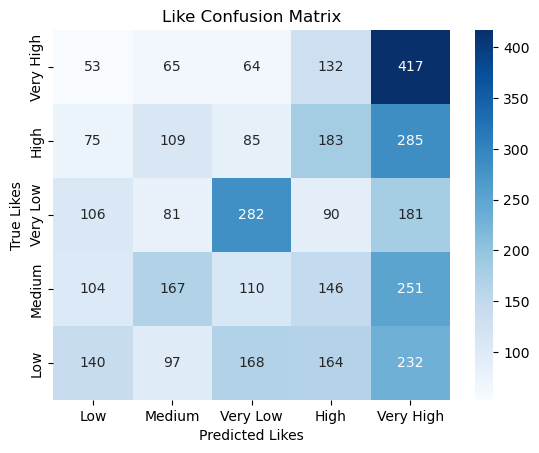

In [134]:
like_mat_df = like_pred.select("LikeLabel", "prediction")
like_mat_df = like_mat_df.toPandas()

like_true = like_mat_df["LikeLabel"]
like_predicted = like_mat_df["prediction"]

like_cm = confusion_matrix(like_true, like_predicted)
like_cm_plot = sns.heatmap(like_cm, cmap="Blues", xticklabels=like_class_names, yticklabels=like_class_names, annot=True, fmt="d")
like_cm_plot.set_xlabel("Predicted Likes")
like_cm_plot.set_ylabel("True Likes")
like_cm_plot.set_title("Like Confusion Matrix")
like_cm_plot.invert_xaxis()

plt.show()

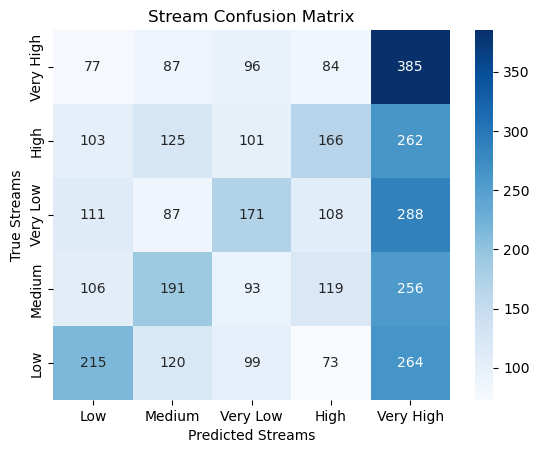

In [131]:
stream_mat_df = stream_pred.select("StreamLabel", "prediction")
stream_mat_df = stream_mat_df.toPandas()

stream_true = stream_mat_df["StreamLabel"]
stream_predicted = stream_mat_df["prediction"]

stream_cm = confusion_matrix(stream_true, stream_predicted)
stream_cm_plot = sns.heatmap(stream_cm, cmap="Blues", xticklabels=like_class_names, yticklabels=like_class_names, annot=True, fmt="d")
stream_cm_plot.set_xlabel("Predicted Streams")
stream_cm_plot.set_ylabel("True Streams")
stream_cm_plot.set_title("Stream Confusion Matrix")
stream_cm_plot.invert_xaxis()
plt.show()

In [63]:
importances = like_model.stages[-1].featureImportances

features_list = assembler.getInputCols()

importance_df = pd.DataFrame({
    "Feature": features_list,
    "Importance": importances.toArray()
}).sort_values(by="Importance", ascending=False)

print(importance_df)

            Feature  Importance
2          Loudness    0.164379
0      Danceability    0.108765
3       Speechiness    0.103285
7           Valence    0.096712
1            Energy    0.095881
4      Acousticness    0.095334
6          Liveness    0.092123
5  Instrumentalness    0.089235
8             Tempo    0.088995
9               Key    0.065290


Text(0.5, 1.0, 'Feature Importance')

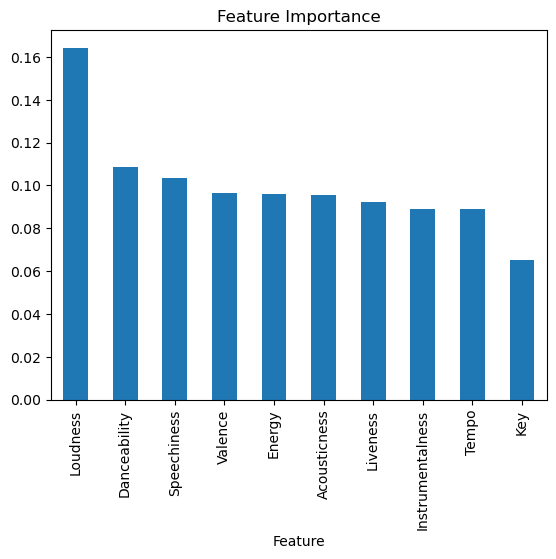

In [64]:
bar = importance_df.plot.bar(x="Feature", y="Importance", legend=False)
plt.title("Feature Importance")

Text(0.5, 1.0, 'Loudness Distribution by Like Categories')

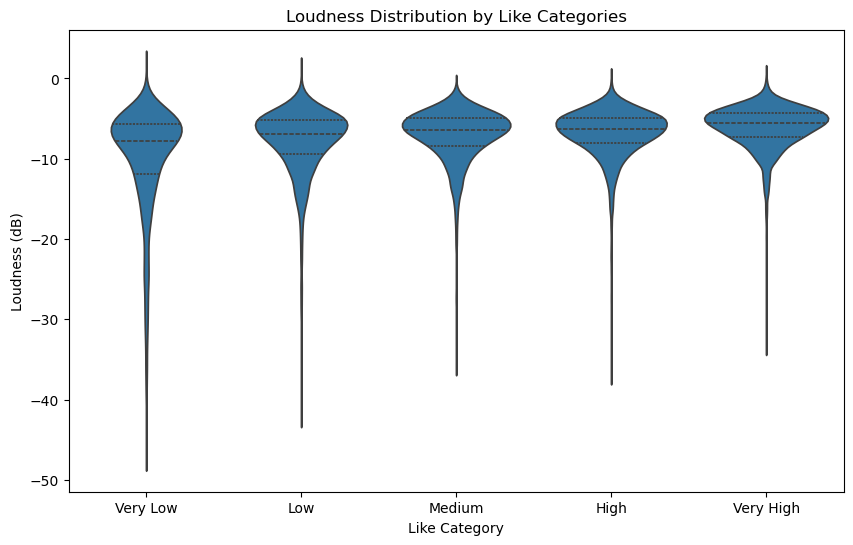

In [65]:
plot_df = df.select("LikeCategories", "StreamCategories", "Loudness").toPandas()
order = ["Very Low", "Low", "Medium", "High", "Very High"]

plt.figure(figsize=(10, 6))
like_loudness_plot = sns.violinplot(x="LikeCategories", y="Loudness", data=plot_df, order=order, inner="quartile")
# like_loudness_plot.set_ylim(-20, 5)
like_loudness_plot.set_xlabel("Like Category")
like_loudness_plot.set_ylabel("Loudness (dB)")
plt.title("Loudness Distribution by Like Categories")

Text(0.5, 1.0, 'Loudness Distribution by Stream Categories')

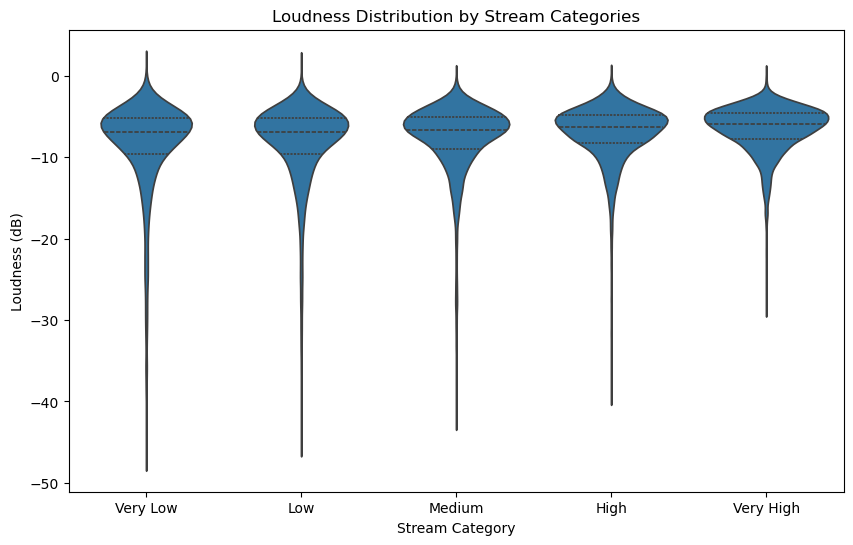

In [66]:
plt.figure(figsize=(10, 6))
stream_loudness_plot = sns.violinplot(x="StreamCategories", y="Loudness", data=plot_df, order=order, inner="quartile")
# stream_loudness_plot.set_ylim(-20, 5)
stream_loudness_plot.set_xlabel("Stream Category")
stream_loudness_plot.set_ylabel("Loudness (dB)")
plt.title("Loudness Distribution by Stream Categories")